In [1]:
import os

# visualizing data
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import numpy as np
from imblearn.over_sampling import SMOTE  
train_on_gpu = torch.cuda.is_available()
# train_on_gpu = False
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


In [2]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd

from skimage import io, transform
%matplotlib inline

In [3]:
from __future__ import print_function, division

from skimage import io, transform
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import img_as_float, random_noise
from skimage.morphology import disk
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage.filters import gaussian, unsharp_mask
from skimage import exposure

class ImageLoader(Dataset):
  

    def __init__(self, data_frame, transform=None, Is_tumor=False, Is_train=False, randomize_images =True, add_noise=False):

        self.data_frame = data_frame
        self.transform = transform
        self.Is_train = Is_train        
        self.randomize_images = randomize_images
        self.add_noise= add_noise
        self.filepath= 'test/image/' 
        if Is_tumor:
            self.class_dic = {'meningioma_tumor':0,'glioma_tumor':0, 'pituitary_tumor':0, 'no_tumor':1}
        else:
            self.class_dic = {'meningioma_tumor':0,'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
        
        
    def __len__(self):
        return len(self.data_frame)
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
      
        image = io.imread(self.filepath + str(self.data_frame.iloc[idx, 0]), as_gray=True)
#         print(image.shape)
#         image = unsharp_mask(image, radius=3, amount=1)
#         image = exposure.equalize_hist(image)
#         image = exposure.equalize_adapthist(image, clip_limit=0.03)
        
        if self.Is_train and self.randomize_images and np.random.random() > 0.5:
            image = image[:, ::-1]
             
        labels = self.data_frame.iloc[idx, 1]
        if self.add_noise==True and labels=='no_tumor' and np.random.random() > 0.8:
            image = image[:, ::-1]
            image = resize(image, (224,224),anti_aliasing=True)
            image = image[3:-4, 3:-4]
            image = gaussian(image, sigma=2, multichannel=False)
        elif self.add_noise==True and labels=='meningioma_tumor' and np.random.random() > 0.95:
            image = image[:, ::-1]
            image = resize(image, (224,224),anti_aliasing=True)
            image = image[3:-4, 3:-4]
            image = gaussian(image, sigma=2, multichannel=False)           
        labels = self.class_dic[str(labels)]
        labels = np.array(labels)
        labels = labels.astype(np.float)
        sample = {'image': image, 'labels': labels}
        
            
        if self.transform:
            sample = self.transform(sample)
        return sample
    


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size_height,output_size_width):
        assert isinstance(output_size_height, (int, tuple))
        assert isinstance(output_size_width, (int, tuple))
        self.output_size_height = output_size_height
        self.output_size_width = output_size_width

    def __call__(self, sample):
        
            
              
        new_h, new_w = self.output_size_height,self.output_size_width
        new_h, new_w = int(new_h), int(new_w)
        
        image, labels = sample['image'], sample['labels']
        img = transform.resize(image, (new_h, new_w))
        
        
        return {'image': img, 'labels': labels}


    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    


    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        image = np.expand_dims(image, axis=2)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}


    
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze(2), cmap=plt.get_cmap('gray'))  # convert from Tensor image

def make_weights_for_balanced_classes(dataframe, nclasses):                        
    count = [0] * nclasses                                                      
                                                             
        
    if nclasses==2:
        class_dic = {'meningioma_tumor':0,'glioma_tumor':0, 'pituitary_tumor':0, 'no_tumor':1}
        for idx in range(len(dataframe)):            
            count[class_dic[dataframe.iloc[idx, 1]]] += 1 
    else:
        class_dic = {'meningioma_tumor':0,'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
        for idx in range(len(dataframe)):            
            count[class_dic[dataframe.iloc[idx, 1]]] += 1  
    
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(dataframe)
    for idx in range(len(dataframe)):                                          
        weight[idx] = weight_per_class[class_dic[dataframe.iloc[idx, 1]]]                                  
    return weight 

20
torch.Size([2, 1, 256, 256])


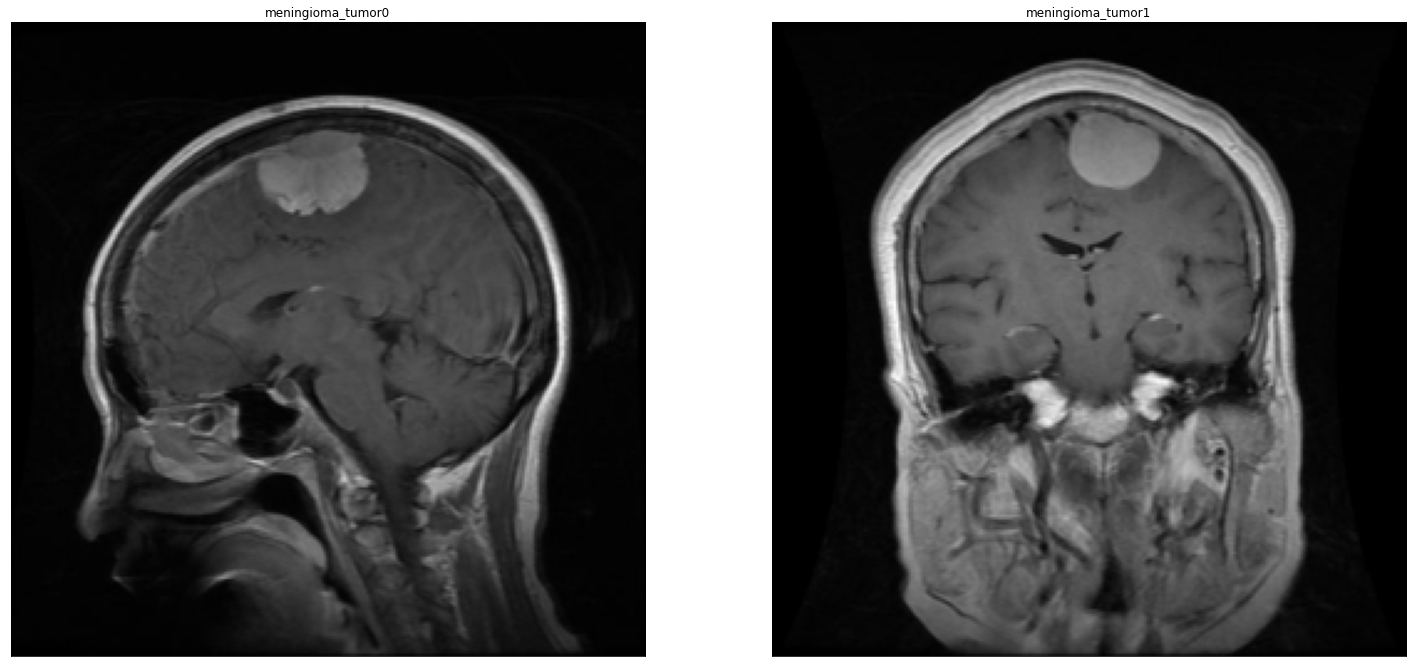

In [4]:
filepath = 'test/image/' 
pathidentity='test/'+'label.csv'
Tumnor_detection=False

data = pd.read_csv(pathidentity)


df=data
np.random.seed(33)
df = shuffle(df)
part=len(df)//10
print(part)
df_test = df

thesize=256

brain_dataset_test = ImageLoader(df_test,transform=transforms.Compose([
                                               Rescale(thesize,thesize),
                                               ToTensor()
                                           ]),Is_tumor=Tumnor_detection)

batch_size=2
num_workers=0

if Tumnor_detection:
    classes = ['tumor', 'no_tumor']
    num_classes=2
    no_tumor_res=1
else:  
    # 0 for meningioma, 1 for glioma, 2 for pituitary tumor
    classes = ['meningioma_tumor','glioma_tumor', 'pituitary_tumor', 'no_tumor']
    num_classes=4
    no_tumor_res=3


test_loader = DataLoader(dataset=brain_dataset_test, batch_size=batch_size, 
                         shuffle=True, num_workers=num_workers)


import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
fig = plt.figure(figsize=(25,50))

row_size=1
counter=0
plot_image=[]
plot_label=[]
class_count=[0 for _ in range(num_classes)]
    

for i_batch, sample_batched in enumerate(test_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    print(images_batch.size())
    images_batch = images_batch.numpy()
    labels_batch = labels_batch.int()
    for idx in np.arange(batch_size):       
        plot_image.append(images_batch[idx])
        plot_label.append(str(classes[labels_batch[idx]])+str(counter))
        counter+=1
        if counter == batch_size:
            break
    if counter == batch_size:
        break         
plot_image=np.array(plot_image)
plot_label=np.array(plot_label)

for idx in np.arange(batch_size):
    ax = fig.add_subplot(row_size, batch_size/row_size, idx+1, xticks=[], yticks=[])
    imshow(plot_image[idx])
    ax.set_title(plot_label[idx])




In [6]:

import torch.nn.functional as F

# define the CNN architecture
class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
       
        # max pooling layer
        self.pool1 = nn.MaxPool2d((2, 2),2)
        #linear layer (512 -> 2)
        self.fc1 = nn.Linear(50176,1024) # for size 224
#         self.fc1 = nn.Linear(65536,1024) # for size 256
        self.fc3 = nn.Linear(1024, 4)
#         self.LeakyReLU = nn.LeakyReLU(0.01)
        self.LeakyReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.30)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x =  self.pool1(self.LeakyReLU(self.conv1(x)))
        x = self.pool1(self.LeakyReLU(self.conv2(x)))
        x =  self.pool1(self.LeakyReLU(self.conv3(x)))
        x =  self.pool1(self.LeakyReLU(self.conv4(x)))
#         print(x.size())
        # flatten image input
        x = x.view(-1, 50176) # for size 224
#         x = x.view(-1, 65536) # for size 256

        
        # add 1st hidden layer, with relu activation function
        x = self.LeakyReLU(self.fc1(x))
        x = self.dropout(x)
        x = self.fc3(x)
#         x=F.tanh(x)
        return x

# # create a complete CNN
# # model = Net()


In [7]:
from Models.Discriminator_densenet import DenseNet, densenet201
from Models.Discriminator_residualattentionmodel import ResidualAttentionModel_92_32input_update, ResidualAttentionModel_92
from Models.Discriminator_VGG import vgg19, vgg19_bn

model0 = densenet201(num_classes=num_classes)
model1 = vgg19(num_classes=num_classes)
# model1 = myNet()
model2 = ResidualAttentionModel_92()

if train_on_gpu:
    model0.cuda()
    model1.cuda()
    model2.cuda()
criterion = nn.CrossEntropyLoss()
model0.load_state_dict(torch.load('densenet201ACC95.pt'))
model1.load_state_dict(torch.load('VGG19_ACC93.pt'))
# model1.load_state_dict(torch.load('mynetacc94.pt'))
model2.load_state_dict(torch.load('ResidualAttentionModel_92ACC94.pt'))

<All keys matched successfully>

In [8]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(20))
class_total = list(0. for i in range(20))

model0.eval()
model1.eval()
model2.eval()
# iterate over test data
counter=0
for i_batch, sample_batched in enumerate(test_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    img=images_batch.float()
    img1=resize(img, (batch_size,1,224,224),anti_aliasing=True)
    img1=torch.from_numpy(img1)
    target = labels_batch.long()
    if train_on_gpu:
        img,  target, img1 = img.cuda(), target.cuda(),img1.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model0(img)+model1(img)+model2(img1)
    loss = criterion(output/3, target)
    test_loss += loss.item()*img.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
#         print(counter)
        if counter==200:
            break
#         label = target.data
#         class_correct[label] += correct.item()
        label = target[i].data
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        counter += 1
       

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.118860

Test Accuracy of meningioma_tumor: 97% (66/68)
Test Accuracy of glioma_tumor: 86% (37/43)
Test Accuracy of pituitary_tumor: 100% (52/52)
Test Accuracy of no_tumor: 100% (37/37)

Test Accuracy (Overall): 96% (192/200)


In [9]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(20))
class_total = list(0. for i in range(20))

model0.eval()
model1.eval()
model2.eval()
# iterate over test data
counter=0
for i_batch, sample_batched in enumerate(test_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    img=images_batch.float()
    img1=resize(img, (batch_size,1,224,224),anti_aliasing=True)
    img1=torch.from_numpy(img1)
    target = labels_batch.long()
    if train_on_gpu:
        img,  target, img1 = img.cuda(), target.cuda(),img1.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model0(img)
    loss = criterion(output, target)
    test_loss += loss.item()*img.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
#         print(counter)
        if counter==300:
            break
#         label = target.data
#         class_correct[label] += correct.item()
        label = target[i].data
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        counter += 1
       

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.183316

Test Accuracy of meningioma_tumor: 95% (65/68)
Test Accuracy of glioma_tumor: 81% (35/43)
Test Accuracy of pituitary_tumor: 96% (50/52)
Test Accuracy of no_tumor: 100% (37/37)

Test Accuracy (Overall): 93% (187/200)


In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(20))
class_total = list(0. for i in range(20))

model0.eval()
model1.eval()
model2.eval()
# iterate over test data
counter=0
for i_batch, sample_batched in enumerate(test_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    img=images_batch.float()
    img1=resize(img, (batch_size,1,224,224),anti_aliasing=True)
    img1=torch.from_numpy(img1)
    target = labels_batch.long()
    if train_on_gpu:
        img,  target, img1 = img.cuda(), target.cuda(),img1.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model1(img)
    loss = criterion(output, target)
    test_loss += loss.item()*img.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
#         print(counter)
        if counter==300:
            break
#         label = target.data
#         class_correct[label] += correct.item()
        label = target[i].data
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        counter += 1
       

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.154263

Test Accuracy of meningioma_tumor: 97% (66/68)
Test Accuracy of glioma_tumor: 86% (37/43)
Test Accuracy of pituitary_tumor: 94% (49/52)
Test Accuracy of no_tumor: 100% (37/37)

Test Accuracy (Overall): 94% (189/200)


In [11]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(20))
class_total = list(0. for i in range(20))

model0.eval()
model1.eval()
model2.eval()
# iterate over test data
counter=0
for i_batch, sample_batched in enumerate(test_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    img=images_batch.float()
    img1=resize(img, (batch_size,1,224,224),anti_aliasing=True)
    img1=torch.from_numpy(img1)
    target = labels_batch.long()
    if train_on_gpu:
        img,  target, img1 = img.cuda(), target.cuda(),img1.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model2(img1)
    loss = criterion(output, target)
    test_loss += loss.item()*img.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
#         print(counter)
        if counter==300:
            break
#         label = target.data
#         class_correct[label] += correct.item()
        label = target[i].data
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        counter += 1
       

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.206300

Test Accuracy of meningioma_tumor: 92% (63/68)
Test Accuracy of glioma_tumor: 86% (37/43)
Test Accuracy of pituitary_tumor: 98% (51/52)
Test Accuracy of no_tumor: 97% (36/37)

Test Accuracy (Overall): 93% (187/200)
